   Unnamed: 0  Sales  CompPrice  Income  Advertising  Population  Price  \
0           1   9.50        138      73           11         276    120   
1           2  11.22        111      48           16         260     83   
2           3  10.06        113      35           10         269     80   

  ShelveLoc  Age  Education Urban   US  
0       Bad   42         17   Yes  Yes  
1      Good   65         10   Yes  Yes  
2    Medium   59         12   Yes  Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        300 non-null    float64
 1   CompPrice         300 non-null    float64
 2   Income            300 non-null    float64
 3   Advertising       300 non-null    float64
 4   Population        300 non-null    float64
 5   Price             300 non-null    float64
 6   Age               300 non-null    float64
 7   Ed

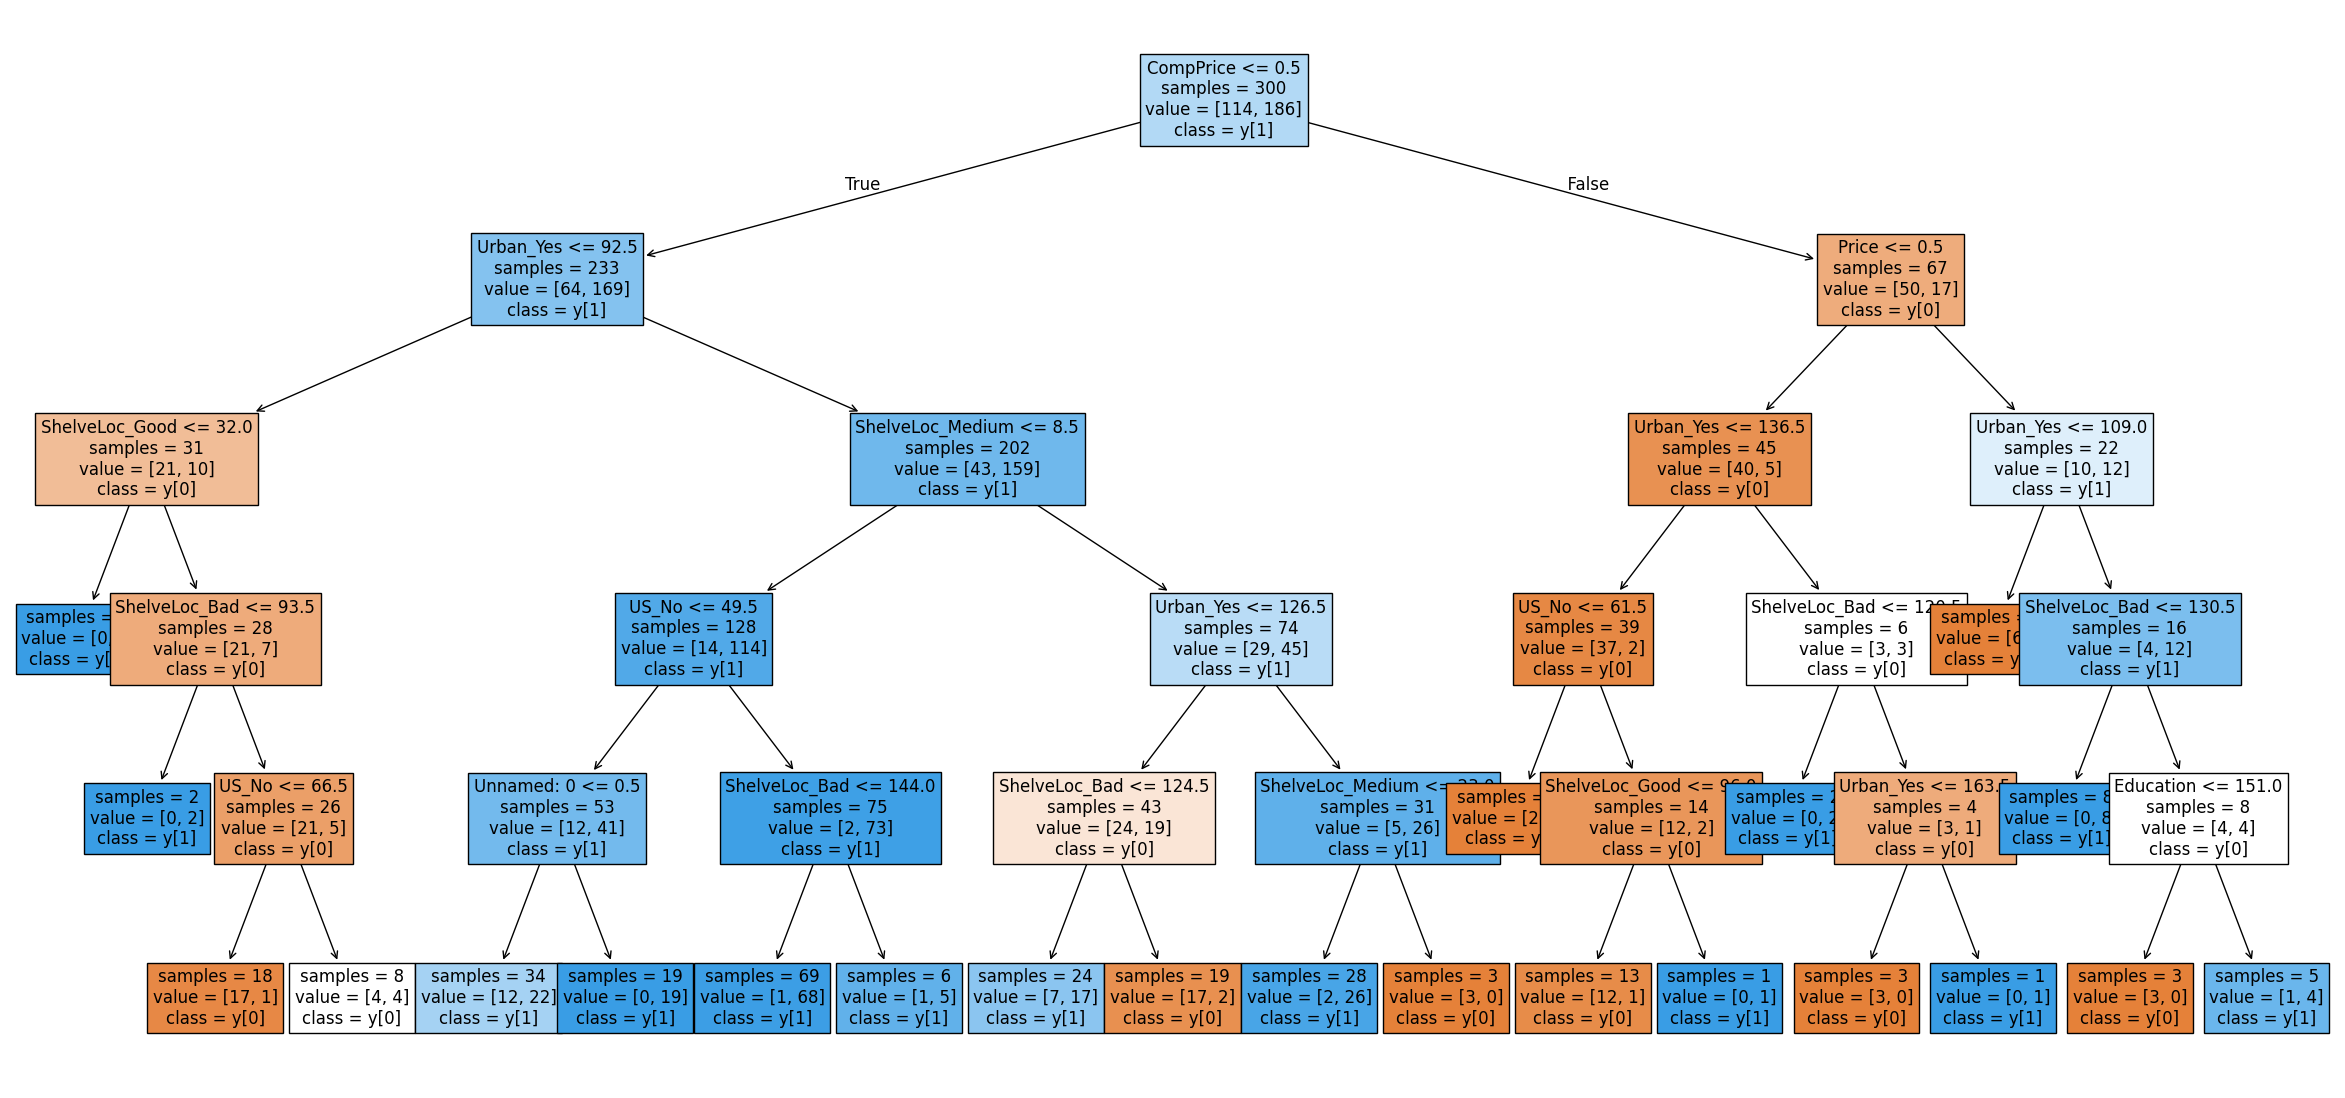

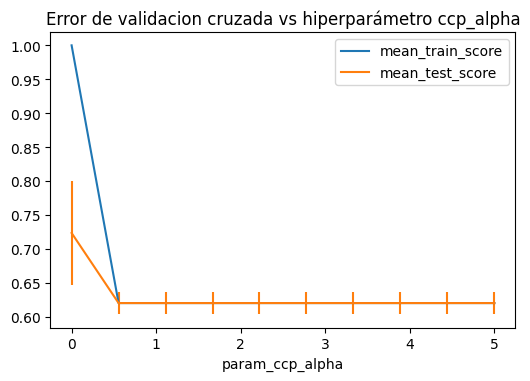

In [9]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

datos = pd.read_csv('../carseats.csv')
print(datos.head(3))

datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
 datos.drop(columns = 'ventas_altas'),
    datos['ventas_altas'],
random_state = 123
)
# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
[('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
remainder='passthrough'
)
# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
max_depth = 5,
criterion = 'gini',
random_state = 123
)
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(30, 14))
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")
print(f" {modelo._parameter_constraints}")
plot = plot_tree(
    decision_tree = modelo,
    feature_names = labels.tolist(),
    class_names = True,
    filled = True,
    impurity = False,
    fontsize = 12,
    ax = ax
)

# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)
print("Matriz de confusión")
print("-------------------")
array_confusion = confusion_matrix(
y_true = y_test,
y_pred = predicciones
)

print(f"Matriz de confusion: {array_confusion}")

accuracy = accuracy_score(
y_true = y_test,
y_pred = predicciones)
print(f"El accuracy de test es: {100 * accuracy} %")


# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}
# Búsqueda por validación cruzada
grid = GridSearchCV(
# El árbol se crece al máximo posible antes de aplicar el pruning
estimator = DecisionTreeClassifier(
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    random_state = 123
),
param_grid = param_grid,
scoring = 'accuracy',
cv = 10,
refit = True,
return_train_score = True
)
grid.fit(X_train_prep, y_train)
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha")

# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)
accuracy = accuracy_score(
y_true = y_test,
y_pred = predicciones)
print(f"El accuracy de test es: {100 * accuracy} %")